# Analysis 
in python

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import nltk
import os

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

DELIM         = " +++$+++ "
CONVO_FILE    = "wikipedia.talkpages.conversations.txt"
USERS_FILE    = "wikipedia.talkpages.userinfo.txt"
ADMINS_FILE   = "wikipedia.talkpages.admins.txt"
POSTS_DF_FILE = "posts_df.pickle"
USERS_DF_FILE = "users_df.pickle"
POSTS_CSV     = "posts.csv"
USERS_CSV     = "users.csv"
NETWORK_FILE  = "users_network.pickle"
CORPUS_DIR    = ("../data/wiki/")
FWORDS_DIR    = '../data/function words/'

function_words = ['conjunctions', 'articles', 'prepositions', 'adverbs', 'quantifiers', 
           'impersonal_pronouns', 'personal_pronouns', 'auxiliary_verbs']

posts = pd.read_pickle(CORPUS_DIR + POSTS_DF_FILE).reset_index()
users = pd.read_pickle(CORPUS_DIR + USERS_DF_FILE).reset_index()

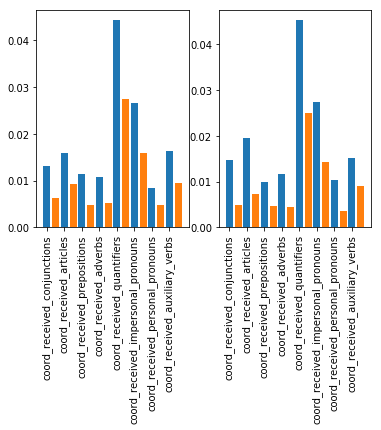

In [4]:
# replicate these charts for admin + eigen_central_bin 

df = users.copy()
coord_labels = ['coord_received_' + x for x in function_words]

std_admin = df[df['admin'] == 1][coord_labels].std()
mean_admin = df[df['admin'] == 1][coord_labels].mean()
std_nadmin = df[df['admin'] == 0][coord_labels].std()
mean_nadmin = df[df['admin'] == 0][coord_labels].mean()

plt.subplot(1,2,1)
plt.xticks(rotation='vertical')
plt.bar(x=[2 * x for x in range(len(coord_labels))], height=mean_admin, tick_label=coord_labels)
plt.bar(x=[2 * x + 1 for x in range(len(coord_labels))], height=mean_nadmin)

std_admin = df[df['eigen_central_bin'] == 1][coord_labels].std()
mean_admin = df[df['eigen_central_bin'] == 1][coord_labels].mean()
std_nadmin = df[df['eigen_central_bin'] == 0][coord_labels].std()
mean_nadmin = df[df['eigen_central_bin'] == 0][coord_labels].mean()

plt.subplot(1,2,2)
plt.xticks(rotation='vertical')
plt.bar(x=[2 * x for x in range(len(coord_labels))], height=mean_admin, tick_label=coord_labels)
plt.bar(x=[2 * x + 1 for x in range(len(coord_labels))], height=mean_nadmin)

plt.show()

## What's up with these perplexities??

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f017ca8e5c0>]], dtype=object)

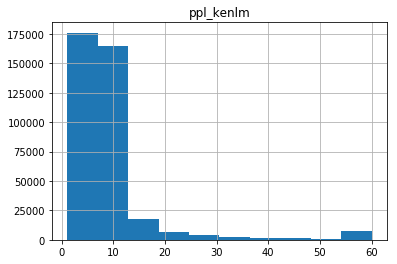

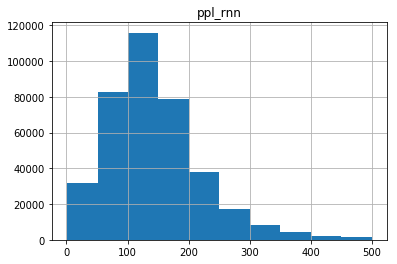

In [5]:
# histograms of twe perplexity measures (outliers excluded)
posts[posts.ppl_kenlm < 60].hist('ppl_kenlm')
posts[posts.ppl_rnn < 500].hist('ppl_rnn')

,ppl_rnn,ppl_kenlm
ppl_rnn,1.000000,-0.004819
ppl_kenlm,-0.004819,1.000000


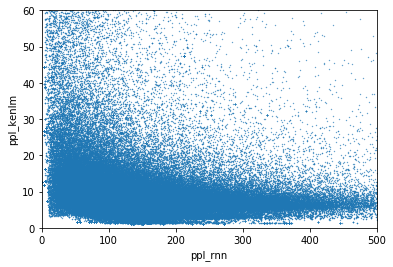

In [6]:
# compare the two perplexity measures directly
posts.plot.scatter('ppl_rnn', 'ppl_kenlm', s=.1, xlim=(0,500), ylim=(0,60))
posts[['ppl_rnn', 'ppl_kenlm']].corr('pearson')

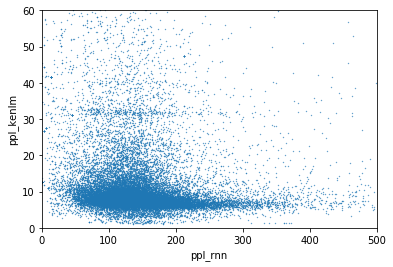

In [7]:
# same comparison aggrigated at the user level (average perpelexity by user)
posts[['user', 'ppl_rnn', 'ppl_kenlm']].groupby('user').mean().plot.scatter('ppl_rnn', 'ppl_kenlm', s=.1, xlim=(0,500), ylim=(0,60))

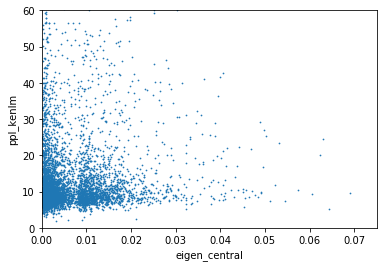

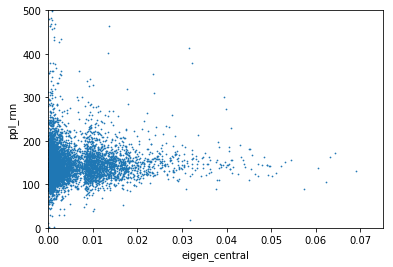

In [8]:
# comparing PPL to centrality for the two measures
user_ppl = posts[['user', 'ppl_rnn', 'ppl_kenlm']].groupby('user').mean()
user_ppl = users[['user', 'eigen_central']].join(user_ppl, on='user')

user_ppl.plot.scatter('eigen_central', 'ppl_kenlm', xlim=(0,.075), ylim=(0,60), s=.5)
user_ppl.plot.scatter('eigen_central', 'ppl_rnn', xlim=(0,.075), ylim=(0,500), s=.5)

In [19]:
# comparing PPL to centrality for the two measures
user_ppl = posts[['user', 'ppl_rnn', 'ppl_kenlm']].groupby('user').mean()
user_ppl = users[['user', 'eigen_central_bin']].join(user_ppl, on='user')
user_ppl = user_ppl.dropna()
groupby = user_ppl[['eigen_central_bin', 'ppl_rnn', 'ppl_kenlm']].groupby('eigen_central_bin')
m = groupby.mean()
std = groupby.std()
print(m)
print(std)
print()

# comparing PPL to adminship for the two measures
user_ppl = posts[['user', 'ppl_rnn', 'ppl_kenlm']].groupby('user').mean()
user_ppl = users[['user', 'admin']].join(user_ppl, on='user')
user_ppl = user_ppl.dropna()
groupby = user_ppl[['admin', 'ppl_rnn', 'ppl_kenlm']].groupby('admin')
m = groupby.mean()
std = groupby.std()
print(m)
print(std)

                      ppl_rnn  ppl_kenlm
eigen_central_bin                       
0.0                149.995755  17.511397
1.0                149.648158  16.991798
                      ppl_rnn  ppl_kenlm
eigen_central_bin                       
0.0                157.714382  53.933876
1.0                 43.727807  24.190828

          ppl_rnn  ppl_kenlm
admin                       
0.0    151.244048  17.804644
1.0    143.849685  15.455781
          ppl_rnn  ppl_kenlm
admin                       
0.0    151.595532  52.169549
1.0     36.506346  22.521330


In [11]:
# looking at posts where the two measures diagree the most
# appears to be short, common posts where KenLM is very high and RNN is very low perplexity
def normalize(max_v, v):
    if v >= max_v:
        return 1
    else:
        return v / max_v
    
rnn_norm = lambda x: normalize(500, x)
kenlm_norm = lambda x: normalize(60, x)

posts_ppl = posts.copy()


posts_ppl['rnn_norm'] = posts_ppl.ppl_rnn.apply(rnn_norm)
posts_ppl['kenlm_norm'] = posts_ppl.ppl_kenlm.apply(kenlm_norm)
posts_ppl['ppl_diff'] = abs(posts_ppl.kenlm_norm - posts_ppl.rnn_norm)

posts_ppl[posts_ppl.clean_text != ''].sort_values('ppl_diff', ascending=False)[['ppl_diff', 'ppl_kenlm', 'ppl_rnn', 'clean_text']].head(100)

,ppl_diff,ppl_kenlm,ppl_rnn,clean_text
90301,0.993828,873.208116,3.085854,"\"""
270610,0.993804,2234.937265,3.098152,"''\"""
361215,0.993721,73.431943,3.139560,'''
239701,0.993721,73.431943,3.139560,'''
247510,0.993721,73.431943,3.139560,'''
325439,0.993721,73.431943,3.139560,'''
85001,0.993721,73.431943,3.139560,'''
253495,0.993721,73.431943,3.139560,'''
129099,0.993721,73.431943,3.139560,'''
354419,0.993721,73.431943,3.139560,'''


## Trying out MDLA
Multi-dimensional linguistic analysis - [I. Clarke & J. Grieve, 2017](http://www.aclweb.org/anthology/W17-3001)

In [13]:
# predict Louvian community from linguistic style
from sklearn.linear_model import LogisticRegression

df = users.dropna(subset=['community']).copy()
df['community'] = df['community'].map(int)
X = df[list(map(lambda x: x + '_freq', function_words)) + ['bold_freq', 'links_freq', 'italics_freq']]
y = df['community']

model = LogisticRegression()
model.fit(X, y)
model.score(X,y)

0.072191154041687855

In [17]:
# predict Eigenvector centrality from linguistic style
# R^2
from sklearn.linear_model import LinearRegression

df = users.dropna(subset=['eigen_central_bin']).copy()
X = df[list(map(lambda x: x + '_freq', function_words)) + ['bold_freq', 'links_freq', 'italics_freq']]
y = df['eigen_central_bin']

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.0043911240863239165

In [15]:
# predict Adminship from linguistic style
from sklearn.linear_model import LinearRegression

df = users.dropna(subset=['admin']).copy()
X = df[list(map(lambda x: x + '_freq', function_words)) + ['bold_freq', 'links_freq', 'italics_freq']]
y = df['admin']

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.0079773692883852165